In [28]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## PolyA gene detection

What fraction of polyA genes from the annotation do we detect with >= 1 TPM in any library?

In [2]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='gene',
                   min_tpm=1,
                   gene_subset='polya')

Calculating gene TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # genes detected: 39285
# genes >= 1 tpm: 33946
Subsetting on polya genes
Number of genes reported: 32160


In [3]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene')

In [6]:
polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.index)

print('Detected {} / {} annotated polyA genes'.format(n_det_polya, n_polya))

Detected 32160 / 49472 annotated polyA genes


How many genes of each biotype category are there in the annotation and detected by us?

In [10]:
# get detected genes w/o subsetting on polyA genes
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='gene',
                   min_tpm=1)

Calculating gene TPM values
Enforcing minimum TPM
Total # genes detected: 39285
# genes >= 1 tpm: 33946
Number of genes reported: 33946


In [11]:
df = df.merge(gene_df, how='left', left_index=True, right_on='gid')
temp = df[['gid', 'biotype_category']].groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'gid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

,biotype_category,detected_counts,gencode_counts,prop_detected
3,protein_coding,18612,19969,0.932045
0,lncRNA,9766,15006,0.650806
4,pseudogene,3782,14497,0.260882
2,other,1509,7426,0.203205
1,miRNA,277,1881,0.147262


How many genes in other biotype categories do we detect and what proportion of the annotation does this represent?

In [14]:
temp = df[['gid', 'biotype', 'biotype_category']].groupby(['biotype', 'biotype_category']).count()
temp.reset_index(inplace=True)
temp.rename({'gid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_counts, on='biotype', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)

"Other" genes

In [15]:
temp.loc[temp.biotype_category == 'other']

,biotype,biotype_category,detected_counts,gencode_counts,prop_detected
29,scRNA,other,1.0,1,1.000000
6,Mt_rRNA,other,2.0,2,1.000000
1,IG_C_gene,other,14.0,14,1.000000
9,TR_C_gene,other,6.0,6,1.000000
7,Mt_tRNA,other,10.0,22,0.454545
8,TEC,other,457.0,1060,0.431132
28,ribozyme,other,3.0,8,0.375000
26,rRNA,other,16.0,58,0.275862
11,TR_J_pseudogene,other,1.0,4,0.250000
12,TR_V_gene,other,24.0,106,0.226415


Psuedogenes

In [16]:
temp.loc[temp.biotype_category == 'pseudogene']

,biotype,biotype_category,detected_counts,gencode_counts,prop_detected
36,transcribed_unitary_pseudogene,pseudogene,96.0,124,0.774194
37,transcribed_unprocessed_pseudogene,pseudogene,592.0,885,0.668927
35,transcribed_processed_pseudogene,pseudogene,248.0,481,0.515593
38,translated_processed_pseudogene,pseudogene,1.0,2,0.500000
25,pseudogene,pseudogene,10.0,22,0.454545
21,polymorphic_pseudogene,pseudogene,18.0,41,0.439024
39,unitary_pseudogene,pseudogene,22.0,95,0.231579
22,processed_pseudogene,pseudogene,2247.0,10198,0.220337
40,unprocessed_pseudogene,pseudogene,548.0,2649,0.206871


Differences in lengths of detected vs. non detected genes

In [8]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='gene',
                   min_tpm=1,
                   gene_subset='polya')

Calculating gene TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # genes detected: 39285
# genes >= 1 tpm: 33946
Subsetting on polya genes
Number of genes reported: 32160


In [9]:
gene_df, _, _ = get_gtf_info(how='gene', subset='polya')

In [12]:
df.reset_index(inplace=True)
df = df['annot_gene_id'].to_frame()

df = df.merge(gene_df, how='outer',
              left_on='annot_gene_id', right_on='gid')

In [14]:
df['detected'] = True
df.loc[df.annot_gene_id.isnull(), 'detected'] = False

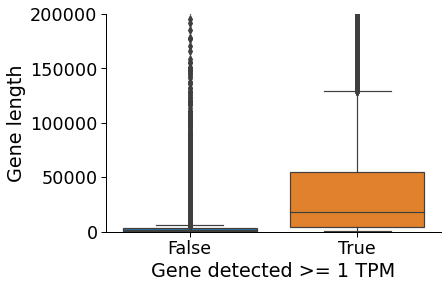

In [25]:
opref = 'figures/'

sns.set_context('paper', font_scale=2)

ax = sns.boxplot(data=df, y='length', x='detected')

xlabel = 'Gene detected >= 1 TPM'
ylabel = 'Gene length'
_ = ax.set(xlabel=xlabel, ylabel=ylabel, ylim=(0,200000))
# _ = ax.set(xlabel=xlabel, ylabel=ylabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('{}_gene_det_1_tpm_len.pdf'.format(opref), \
            dpi=300, bbox_inches='tight')

GO on polyA genes that are not detected at >= 1 TPM

In [46]:
dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human']
bm = gp.parser.Biomart()
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
datasets.loc[datasets.Description.str.contains('Human')]

,Name,Description
196,hsapiens_gene_ensembl,Human genes (GRCh38.p13)


In [47]:
gids = df.loc[~df.detected, 'gid'].str.rsplit('.', n=1, expand=True)[0].to_frame()
gids = gids.squeeze().str.strip().tolist()
gids = bm.query(dataset='hsapiens_gene_ensembl',
           attributes=['ensembl_gene_id', 'external_gene_name'],
           filters={'ensembl_gene_id': gids})
gids = gids.loc[~gids.external_gene_name.isna()]
gnames = gids.external_gene_name.squeeze().str.strip().tolist()
go = gp.enrichr(gene_list=gnames,
                gene_sets=dbs,
                organism='Human',
                description='undet_genes',
                outdir='undet_genes_GO',
                cutoff=0.5)

2022-01-05 16:45:46,550 Warning: No enrich terms using library GO_Cellular_Component_2021 when cutoff = 0.5


In [49]:
# names = gp.get_library_name('Human')
# names
